# Extract and analyse summary features

The clustered and projected data can be used to extract different features:

- size per cluster
- mean intensity per cluster
- TODO add more

The features are saved as an adata object.

In [2]:
from miann.tl import Experiment, FeatureExtractor
import os
from miann.pl import plot_mean_intensity, zscore, get_intensity_change, plot_intensity_change, plot_mean_size, plot_size_change
import anndata as ad
from miann.utils import init_logging
init_logging()

## Extract features
Features can be extracted with 
```
# intensity features
python extract_features.py test/CondVAE_pert-CC clustering_0.5 intensity
# spatial co-occurrence
python extract features.py test/CondVAE_pert-CC clustering_0.5 --co-logspace co-occurrence
```


In [2]:
exp = Experiment.from_dir('test/CondVAE_pert-CC')
# just use one dir here, for extracting all features, run the script
data_dir = exp.data_params['data_dirs'][0]
extr = FeatureExtractor(exp, data_dir=data_dir, cluster_name='clustering_0.5', 
                        cluster_dir='aggregated/sub-0.005')

AssertionError: no config.json in test/CondVAE_pert-CC

In [19]:
# extract intensity features
extr.extract_intensity_size()

INFO:FeatureExtractor:Calculating clustering_0.5 (col: clustering_0.5) mean and size for 184A1_unperturbed/I09
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['clustering_0.5', 'y', 'x', 'obj_ids', 'latent', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'mpp', 'labels', 'clustering_0.5', 'latent']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09
INFO:MPPData:Restricted channels to 34 channels
INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per chan

In [ ]:
# extract co-occurence scores: logspace from 2px to 80px
interval = np.logspace(np.log2(2),np.log2(80),10, base=2).astype(np.float32)
extr.extract_co_occurrence(interval)

## Explore extracted features
TODO mean intensity: update using workflow notebook

### Intensity features

In [7]:
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad')) for data_dir in exp.data_params['data_dirs']]

# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')
zscore(adata, limit_to_groups={'perturbation_duration':'unperturbed'})

In [5]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'perturbation_duration':'unperturbed'}, dendrogram=True, layer='zscored', cmap='bwr', vmin=-10, vmax=10)
plot_mean_size(adata, groupby_row='cluster', groupby_col='perturbation_duration', normby_row='all', vmax=0.3)

In [ ]:
res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference='unperturbed', color='logfoldchange', size='pval')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference='unperturbed', color='logfoldchange', size='pval', norm_by_group='all')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2)

### Co-occurrence scores
TODO co-occurrence name!! 

In [101]:
from miann.pl import plot_co_occurrence, plot_co_occurrence_grid

In [18]:
exp = Experiment.from_dir('test/CondVAE_pert-CC')
# load and concat all adatas
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad')) for data_dir in exp.data_params['data_dirs']]

# get combined adata
adata = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')

INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005


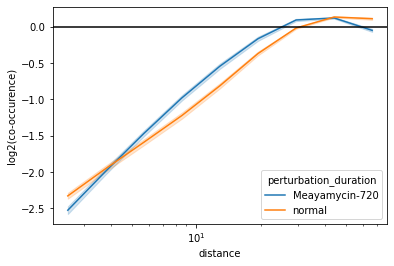

In [102]:
# plot meam co-occ scores
condition = 'perturbation_duration'
condition_values = None

# for one cluster-cluster pairing
plot_co_occurrence(adata, '0', '1', condition, condition_values)

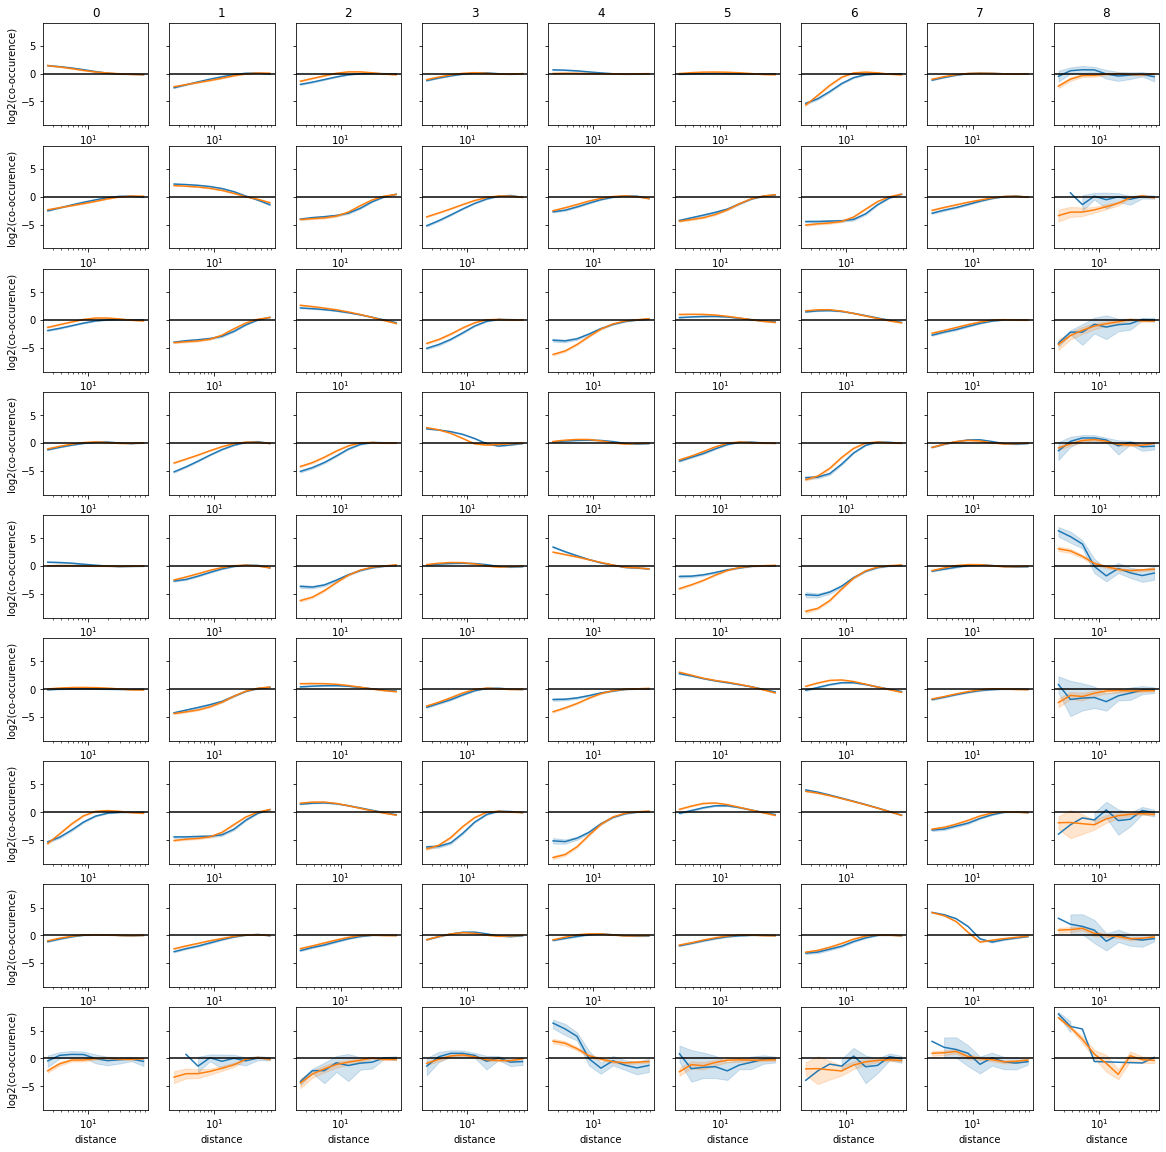

In [103]:
# for all cluster pairings
fig, axes = plot_co_occurrence_grid(adata, condition, condition_values, legend=False, ci=95, figsize=(20,20))